# Active Session I: Classification

# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Probe into the Data

In this dataset, we will look into the relationship between airfoil design and its relationship with noise generation. 

This NASA data set was obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel. It comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments. 

Attribute Information:

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels. 


# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

In [2]:
# Data Preparation
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# ML Algorithms to be used
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as LGBMClassifier

#If you are working on local machine:
# pip install lightgbm


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. Pandas library is a practical way to load and read the data from an url. Since the data is only given as tabulated values, we need to add the name of the features as well. 

In [4]:
# Loading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
new_names = ['frequency','angle_attack','chord_length','Free-stream_velocity','displacement_thickness','sound_pressure']
data = pd.read_csv(url, names=new_names, delimiter='\t')
data.head()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


## Data Exploration
Here we will look into the statistics of the data, identify any missing values or categorical features that is needed to be further process.

Let’s analyze our dataset first. Use dataset.head(n) to display top n data. You can change dataset.head(n) to dataset.sample(n) to display randomly picked data:

In [5]:
 data.head(5)

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
data.sample(5)

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
1384,1000,8.9,0.1016,71.3,0.010309,135.433
1015,12500,4.8,0.0254,71.3,0.000849,127.688
265,2000,2.0,0.2286,55.5,0.003135,124.612
226,4000,0.0,0.2286,39.6,0.002535,123.465
1042,8000,4.8,0.0254,39.6,0.000907,131.346


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   frequency               1503 non-null   int64  
 1   angle_attack            1503 non-null   float64
 2   chord_length            1503 non-null   float64
 3   Free-stream_velocity    1503 non-null   float64
 4   displacement_thickness  1503 non-null   float64
 5   sound_pressure          1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


Let's look into the statistics of the data. This is usually a good starting point to have an idea obout the range of the data, its nature, as well as the missing information for different features:

In [8]:
data.describe()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


If not defined by the user, you can also explore the features with the following command:

In [9]:
data.columns


Index(['frequency', 'angle_attack', 'chord_length', 'Free-stream_velocity',
       'displacement_thickness', 'sound_pressure'],
      dtype='object')

It is also possible to explore individual features:

In [10]:
data['sound_pressure'].median()

125.721

In [11]:
data['sound_pressure'].mean()

124.83594278110434

### Data Visualization

Another important pre-processing step is the data visualization. Histograms are suitable for a holistic view, where we can probe into the data for each attribute.

We can use hist from matplotlib for that purpose:

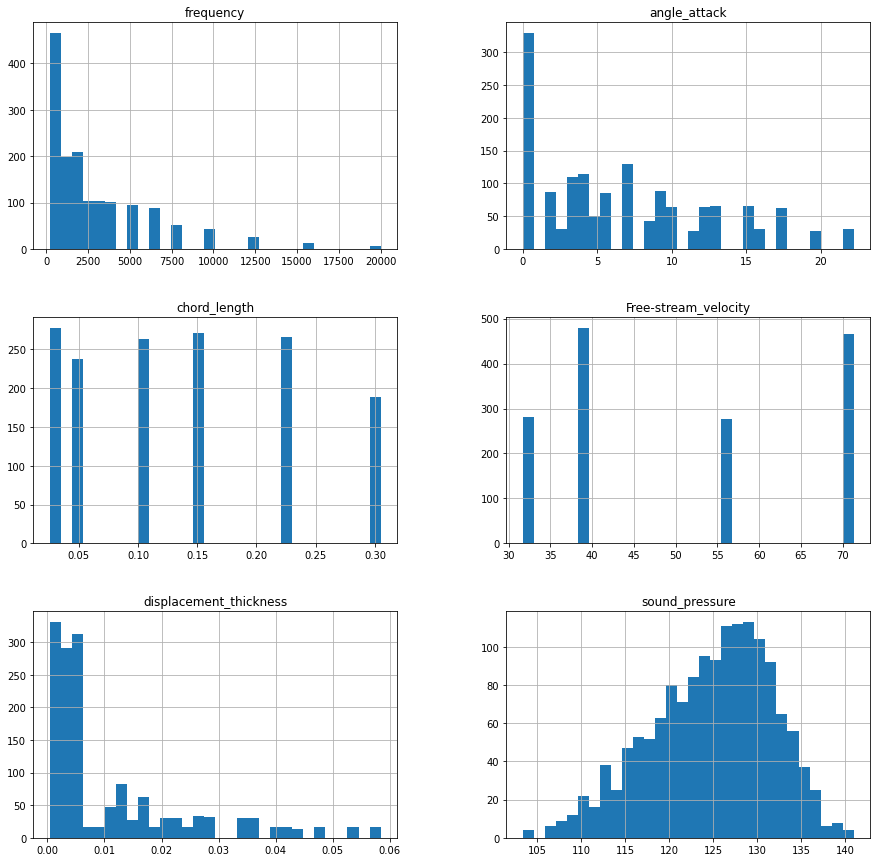

In [12]:
data.hist(bins=30, figsize=(15,15))
plt.show()

It is always a good exercise to look into the data visually and try to see the distributions of the features. 

### Identify nonnumerical values
Some ML algorithms can not handle non-numerical values (NaN: not a number) so you may need to identify the type of the data for each feature and modify it if necessary. It is also quite common that different feature values are missing for different instances / examples so you may need to decide what to do: (i) omit the instance; (ii) replace them with the mean / median / mode of the feature; (iv) substitute them with a value of your choice.

The following line counts the NaNs for each feature for us: 

In [13]:
nanCounter = np.isnan(data).sum()
print(nanCounter)

frequency                 0
angle_attack              0
chord_length              0
Free-stream_velocity      0
displacement_thickness    0
sound_pressure            0
dtype: int64


The data was entirely numerical and composed of numbers. We will see in the following sessions how to handle datasets including non-numerical features in a smart way!

It is also a good exercise to check the uniqueness of the dataset, that is, whether there exists values repeating at different instances:

In [14]:
distinctCounter = data.apply(lambda x: len(x.unique()))
print(distinctCounter)

frequency                   21
angle_attack                27
chord_length                 6
Free-stream_velocity         4
displacement_thickness     105
sound_pressure            1456
dtype: int64


As identified earlier, there are 1503 instances (experimental measurements). Here we realized that these experiments were planned as combinations of 5 input parameters, with unique values of 21x27x6x4x105. 

### Supervised Algorithms: Preparing the Labels

Supervised approach requires labelled data for the training. In this dataset, the objective function is the noise levels (classification) or noise prediction (regression), depending on the question. In both cases, we need to create a feature matrix say X and and label vector Y. We will use Y to train and test our model.

### Creating the Feature Matrix and Labels

In [15]:
dataX = data.copy().drop(['sound_pressure'],axis=1)
dataY = data['sound_pressure'].astype(int).copy()

### Modifying the label vector for classification:

If we are interested in a classification problem, such as identifying the noise levels depending on the airfoil design, we can modify the measured noise levels by converting them into categorical values. 

Assume that we will be performing binary classification with the following criteria: 
If the noise is less than 120 dB, it is "low" and it is classified as "high" if greater than 120 dB. In this exercise, we will use '0' for 'low' and '1' as 'high'. In this scenerio, we can use Binarizer:

In [16]:
from sklearn.preprocessing import Binarizer
#Create an object:
transformer = Binarizer(threshold=120,copy=False)
transformer

Binarizer(copy=False, threshold=120)

In [17]:
#Transforming the data with Binarizer method:
transformer.fit_transform(dataY.values.reshape(-1, 1))

#Lets see how it changes:
dataY.head

<bound method NDFrame.head of 0       1
1       1
2       1
3       1
4       1
       ..
1498    0
1499    0
1500    0
1501    0
1502    0
Name: sound_pressure, Length: 1503, dtype: int64>

In [18]:
dataY.value_counts()

1    1073
0     430
Name: sound_pressure, dtype: int64

For more pre-processing options; you may check:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

### Feature Standardization: Rescaling the Data

Feature engineering is an inseparable aspect of ML models. In many engineering problem, we know from our tradition that combining different features significantly simplifies the problem and help us to focus our experimental / numerical work on the correct data plane. For example, we combine characteristic length, velocity, density and viscosity as Reynolds number and "classify" the flow regime in a pipe in a quite straight-forward way. The same is true on ML algorithms. You can combine features, delete the unrelated ones and rescale the data (similar to what we do in non-dimensional analysis in engineering) to help ML algorithms to seek patterns from an unbiased perspective. In our example, number of features is already small so we do not need to perform any feature engineering. We will come back to this topic in the following weeks.

For the time being, lets just see how much the features are correlated. But first, we will rescale the data. It is  important to remember that most ML algorithms work better if the data is normalized around zero; that it has a mean value of zero with a standard deviation of one. Let's try it ourselves:

In [19]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness
count,1.503000e+03,1.503000e+03,1.503000e+03,1.503000e+03,1.503000e+03
mean,2.837975e-16,-3.495393e-16,-1.624759e-14,-8.558246e-16,2.866045e-16
std,1.000333e+00,1.000333e+00,1.000333e+00,1.000333e+00,1.000333e+00
min,-8.524068e-01,-1.146403e+00,-1.188629e+00,-1.230809e+00,-8.169263e-01
25%,-6.620227e-01,-8.083458e-01,-9.169992e-01,-7.233448e-01,-6.545613e-01
50%,-4.081773e-01,-2.336486e-01,-3.737395e-01,-7.233448e-01,-4.702979e-01
75%,3.533590e-01,5.269801e-01,9.844097e-01,1.312935e+00,3.374462e-01
max,5.430267e+00,2.606032e+00,1.799299e+00,1.312935e+00,3.595917e+00


As you can see, mean value is fixed as zero with a standard deviation (std) of 1. Now let's try to visualize how correlated the data is by creating a correlation matrix. 

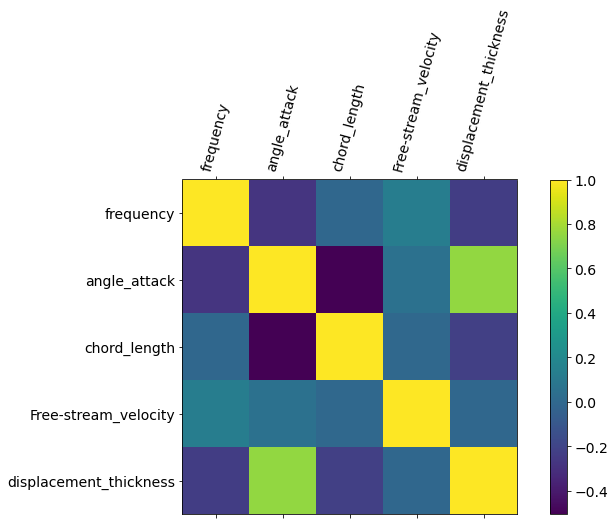

In [20]:
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [21]:
#we can also simply look at the table via pandas:
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness
frequency,1.00,-0.27,-0.00,0.13,-0.23
angle_attack,-0.27,1.00,-0.50,0.06,0.75
chord_length,-0.00,-0.50,1.00,0.00,-0.22
Free-stream_velocity,0.13,0.06,0.00,1.00,-0.00
displacement_thickness,-0.23,0.75,-0.22,-0.00,1.00


What do these numbers mean? 

When it is close to 1, it means that there is a strong positive correlation; At the other extreme; –1, it implies that there is a strong negative correlation. For more:

https://en.wikipedia.org/wiki/Correlation_and_dependence

## Preparing the Dataset for Model

We need to divide our entire dataset into fractions so that we have a training set
from which the machine learning algorithm learns. We also need another set to test the predictions of the ML algorithm. There is no golden rule here: you need to consider the size of your entire dataset. Sometimes 5% is more than enough, sometimes we need to divide 1/3 to have enough test samples. 

In our current examples, number of cases is quite low for a ML project. Therefore, lets leave sufficient number of test cases:





In [22]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.25,
random_state=2020, stratify=dataY)

Here we have frozen the randomness to make the results reproducible. Otherwise, the results would change at every run.

## Cross-Validation
Another rule of thumb is to split
the training set into a sub-training sets and a validation set before seeing its true performance on the test set (25% of the dataset reserved above). This policy is called k-fold cross-validation. The training data is divided into k fractions, trained over (k-1) fractions and tested on the k_th. Here the idea is to increase the generalization of the model as much as possible.

In [23]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

## How to calculate the performance?
In any supervised approach, we need to select a cost function to compare ML predictions with the true values (labels). The
ML algorithm will minimize the cost function by changing its fitting parameters. You should spend some time to define what could be the best cost function for my dataset and my objective. 

In our case, we are dealing with binary classification: so lets try binary classification log loss. You may see the following links for further information:

https://en.wikipedia.org/wiki/Cross_entropy

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html


# ML 101: Logistic Regression

See the lecture notes for the model. Here is a review:

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [24]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 2020
solver = 'liblinear' # For small datasets, it is good.
logReg = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)

In [25]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = logReg

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to logReg.
  model.fit(X_train_fold, y_train_fold)

  #Lets check how good is the fitting. Remember we decided to use log loss.
  # Log loss, aka logistic loss or cross-entropy loss.This is the loss function 
  # used in (multinomial) logistic regression and extensions of it such as neural networks.

  # We will fisrt look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
  #Saving our analysis on the list:
  trainingScores.append(loglossTraining)

  #Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] =model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
  #Saving our analysis on the list:
  cvScores.append(loglossCV)

  #printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set (1127)
loglossLogisticRegression = log_loss(y_train,predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)


Training Log Loss:  0.356738871444132
CV Log Loss:  0.3908671819349346
Training Log Loss:  0.3502213540664088
CV Log Loss:  0.41923690251002477
Training Log Loss:  0.36966720091349914
CV Log Loss:  0.3416906749773056
Training Log Loss:  0.3713443836483212
CV Log Loss:  0.33109771302939867
Training Log Loss:  0.3628451865203291
CV Log Loss:  0.36564683099773154
Logistic Regression Log Loss:  0.3697705832835482


Lets review the results. 

i) In general, what we expect is a training loss smaller than the CV loss. The reason is simple: ML algorithm learns from the training data so it should be better with the training set. CV is the data not included in the training set. In our case, we see that the training and cross-validation losses are similar for each run.

ii) There is no over-fitting. If we had the overfitting, training log loss would be much lower than the cross-validation loss.

## Evaluation Matrices



### Confusion Matrix

In binary classification, we can visualize the results via the confusion matrix:

https://en.wikipedia.org/wiki/Confusion_matrix

In [26]:
y_preds = model.predict(X_train)

In [27]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_train,y_preds)

array([[222, 100],
       [ 35, 770]])

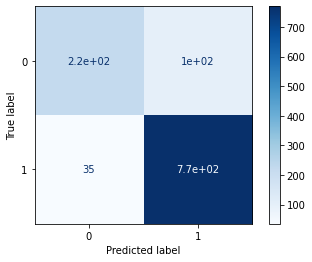

In [28]:
plot_confusion_matrix(model,X_train,y_train,cmap='Blues')

For different color options, you may check:

https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html


### Precision-Recall Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.94')

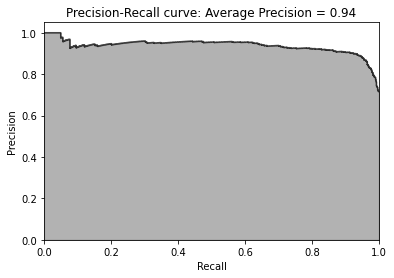

In [29]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))


Here a high recall means that model has captured most of the true positives. As can be seen above, the average precision is good but not perfect. 

### Area under the Receiver Operating Characteristic (ROC) Curve

This is another tool userful for binary classifiers. Below, the dotted line refers to a random classification (50% chance) so a good classifier should be away from the dotted line as much as possible; towards the top & left corner. In the ideal case, we will be at the top-left, implying that we have 0% false positive and 100% true positive rates.

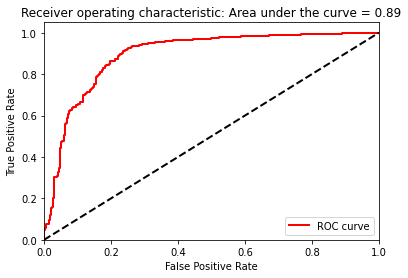

In [30]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()



# Selecting a Different Approach I: Gradient Decent

The data has already been prepared for a ML algorithm for logistic regression. Lets try couple of more classification algoritms and compare their performances. 

We will start with another linear model called gradient decent. There are three main routes to implement it (refer to lecture notes) and here we will test the SGD. 

An important feature of SGDClassifier is the partial_fit method and you can use it to implement the batch learning. If mini-batches are desired, we need to further divide the data into mini-batches. 

In [31]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
loss = 'log' #Since we are looking into log loss.
penalty = 'l2'
alpha = 0.0001 # Regularization constant. Higher the value, higher the regularization.
learning_rate = 'optimal'
l1_ratio = 0.15
early_stopping = False # if true, terminate training when validation score is not improving. 
validation_fraction = 0.05 # portion of the training dataset utilized if early stopping is True. 
random_state = 2020

SGD = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha,l1_ratio=l1_ratio, early_stopping=early_stopping, learning_rate=learning_rate, validation_fraction= validation_fraction, random_state=random_state)

In [32]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#_______________#
#___Modified:___#
model = SGD

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to SGD.
  model.fit(X_train_fold, y_train_fold)

  #Lets check how good is the fitting. Remember we decided to use log loss.
  # Log loss, aka logistic loss or cross-entropy loss.This is the loss function 
  # used in (multinomial) logistic regression and extensions of it such as neural networks.

  # We will fisrt look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
  #Saving our analysis on the list:
  trainingScores.append(loglossTraining)

  #Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] =model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
  #Saving our analysis on the list:
  cvScores.append(loglossCV)

  #printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set (1127)
#_______________#
#___Modified:___#
loglossSGD = log_loss(y_train,predictionsBasedOnKFolds.loc[:,1])
print('-----------------------------------')
print('SGD Log Loss: ', loglossSGD)

Training Log Loss:  0.4130398496630995
CV Log Loss:  0.4810529825188819
Training Log Loss:  0.37237437916146604
CV Log Loss:  0.5148101133493522
Training Log Loss:  0.4272639622450492
CV Log Loss:  0.4152939625190349
Training Log Loss:  0.5676135354483693
CV Log Loss:  0.5332870970516906
Training Log Loss:  0.4330788399084925
CV Log Loss:  0.4554419100747557
-----------------------------------
SGD Log Loss:  0.4800090752763569


## Evaluation Matrices

### Confusion Matrix

In binary classification, we can visualize the results via the confusion matrix:

https://en.wikipedia.org/wiki/Confusion_matrix

In [33]:
y_preds = model.predict(X_train)
confusion_matrix(y_train,y_preds)

array([[136, 186],
       [  9, 796]])

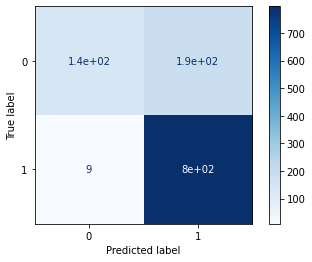

In [34]:
plot_confusion_matrix(model,X_train,y_train,cmap='Blues')

### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.91')

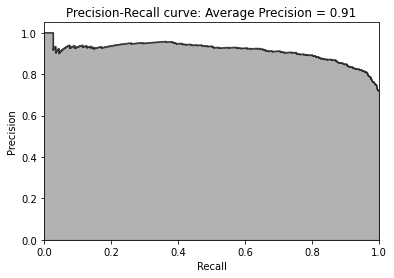

In [35]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))


### Area under the Receiver Operating Characteristic (ROC) Curve

This is another tool userful for binary classifiers. Below, the dotted line refers to a random classification (50% chance) so a good classifier should be away from the dotted line as much as possible; towards the top & left corner. In the ideal case, we will be at the top-left, implying that we have 0% false positive and 100% true positive rates.

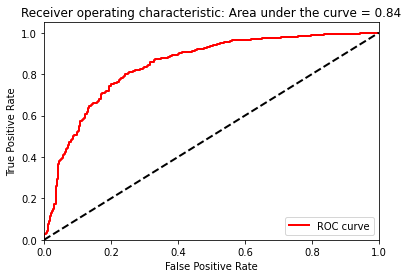

In [36]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Selecting a Different Approach II: Random Forests
Lets try another popular method: Random Forests. 

In [37]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
n_estimators = 10
max_features = 'auto'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2020
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              min_weight_fraction_leaf=min_weight_fraction_leaf,max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state,class_weight=class_weight)


In [38]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#_______________#
#___Modified:___#
model = RFC

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to FRC.
  model.fit(X_train_fold, y_train_fold)

  #Lets check how good is the fitting. Remember we decided to use log loss.
  # Log loss, aka logistic loss or cross-entropy loss.This is the loss function 
  # used in (multinomial) logistic regression and extensions of it such as neural networks.

  # We will fisrt look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
  #Saving our analysis on the list:
  trainingScores.append(loglossTraining)

  #Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] =model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
  #Saving our analysis on the list:
  cvScores.append(loglossCV)

  #printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set (1127)
#_______________#
#___Modified:___#
loglossRFC = log_loss(y_train,predictionsBasedOnKFolds.loc[:,1])
print('-----------------------------------')
print('SGD Log Loss: ', loglossSGD)

Training Log Loss:  0.04691379861352363
CV Log Loss:  0.43699906095162355
Training Log Loss:  0.050414191474556974
CV Log Loss:  0.34056090279074813
Training Log Loss:  0.0438762582148692
CV Log Loss:  0.4516638741046282
Training Log Loss:  0.050452947283897945
CV Log Loss:  0.43328822352995205
Training Log Loss:  0.04627028499790126
CV Log Loss:  0.6289200774494912
-----------------------------------
SGD Log Loss:  0.4800090752763569


### RF Special Property: Feature Importance 
Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). 

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the `feature_importances_` variable. 

In [39]:
pred_comp = model.fit(X_train, y_train)
for name, score in zip(new_names, pred_comp.feature_importances_):
    print(name, score)

frequency 0.5078899615845973
angle_attack 0.10084945043187156
chord_length 0.09809369981835218
Free-stream_velocity 0.05777680855346639
displacement_thickness 0.2353900796117127


## Evaluation Matrices

### Confusion Matrix

In [40]:
y_preds = model.predict(X_train)
confusion_matrix(y_train,y_preds)


array([[319,   3],
       [  1, 804]])

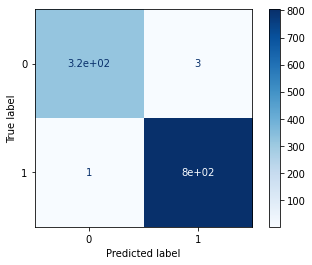

In [41]:
plot_confusion_matrix(model,X_train,y_train,cmap='Blues')

### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.98')

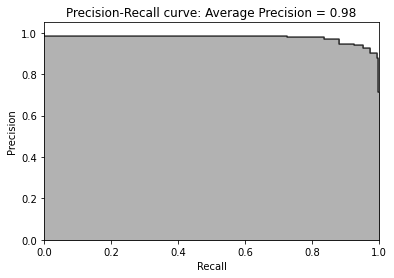

In [42]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

### ROC Curve


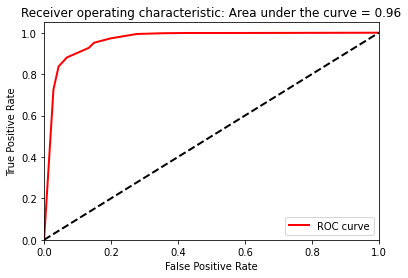

In [43]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Selecting a Different Approach III: Boosting

Introduced by Microsoft in 2017, LightGBM is designed for modeling extremely large data sets of high dimensionality, often being many times faster than XGBoost. 

For its own documentation:
https://lightgbm.readthedocs.io/en/latest/

In [44]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
# https://lightgbm.readthedocs.io/en/latest/Parameters.html#parameters-format

params_LGB = {
'task': 'train',
'application':'binary',
'num_class':1,
'boosting': 'gbdt', # traditional Gradient Boosting Decision Tree
'objective': 'binary',
'metric': 'binary_logloss', #our initial selection
'metric_freq':1, # default = 1, type = int, aliases: output_freq, constraints: metric_freq > 0
'training_metric':False, #set this to true to output metric result over training dataset
'max_depth':4, #limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
'num_leaves': 10, #default = 31, type = int, constraints: 1 < num_leaves <= 131072
'learning_rate': 0.01, #default = 0.1  constraints: learning_rate > 0.0
'feature_fraction': 1.0,  # default = 1.0. #LightGBM will randomly select part of features on each iteration (tree) if feature_fraction smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
#can be used to speed up training or  to deal with over-fitting.
'bagging_fraction': 1.0, # default = 1.0. this will randomly select part of data without resampling. can be used to deal with over-fitting. 0.0 < bagging_fraction <= 1.0
'bagging_freq': 0, # 0 means disable bagging; k means perform bagging at every k iteration
'bagging_seed': 2020, #random seed for bagging
'verbose': -1, #default = 1 controls the level of LightGBM’s verbosity. = 0: Error (Warning), = 1: Info, > 1: Debug  
'num_threads':0 # default = 0, 
# for the best speed, set this to the number of real CPU cores, not the number of threads
# do not set it too large if your dataset is small (for instance, do not use 64 threads for a dataset with 10,000 rows)
}

In [45]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

#_______________#
#___Modified:___#
#model not defined here!

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #_______________#
  #___Modified:___#
  train_LGB = LGBMClassifier.Dataset(X_train_fold, y_train_fold)
  evaluate_LGB = LGBMClassifier.Dataset(X_cv_fold, y_cv_fold, reference = train_LGB)
  #Calling the model for training:
  GBM = LGBMClassifier.train(params_LGB,train_LGB, num_boost_round = 2500, valid_sets = evaluate_LGB, early_stopping_rounds = 150)

  #Lets check how good is the fitting. Remember we decided to use log loss.
  # Log loss, aka logistic loss or cross-entropy loss.This is the loss function 
  # used in (multinomial) logistic regression and extensions of it such as neural networks.
  # We will fisrt look log loss in the training dataset. 
  
  #_______________#
  #___Modified:___#
  loglossTraining = log_loss(y_train_fold, GBM.predict(X_train_fold, num_iteration=GBM.best_iteration))
  
  #Saving our analysis on the list:
  trainingScores.append(loglossTraining)

  #_______________#
  #___Modified:___#
  #Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] =GBM.predict(X_cv_fold, num_iteration=GBM.best_iteration)
  
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
  #Saving our analysis on the list:
  cvScores.append(loglossCV)

  #printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set (1127)
#_______________#
#___Modified:___#
loglossLGBMC = log_loss(y_train,predictionsBasedOnKFolds.loc[:,'prediction'])
print('-----------------------------------')
print('SGD Log Loss: ', loglossLGBMC)

Streaming output truncated to the last 5000 lines.
[1130]	valid_0's binary_logloss: 0.17883
[1131]	valid_0's binary_logloss: 0.178744
[1132]	valid_0's binary_logloss: 0.178734
[1133]	valid_0's binary_logloss: 0.178693
[1134]	valid_0's binary_logloss: 0.178601
[1135]	valid_0's binary_logloss: 0.17866
[1136]	valid_0's binary_logloss: 0.178613
[1137]	valid_0's binary_logloss: 0.178516
[1138]	valid_0's binary_logloss: 0.178499
[1139]	valid_0's binary_logloss: 0.178416
[1140]	valid_0's binary_logloss: 0.17841
[1141]	valid_0's binary_logloss: 0.178321
[1142]	valid_0's binary_logloss: 0.178294
[1143]	valid_0's binary_logloss: 0.178242
[1144]	valid_0's binary_logloss: 0.178202
[1145]	valid_0's binary_logloss: 0.178176
[1146]	valid_0's binary_logloss: 0.178235
[1147]	valid_0's binary_logloss: 0.178191
[1148]	valid_0's binary_logloss: 0.178141
[1149]	valid_0's binary_logloss: 0.178083
[1150]	valid_0's binary_logloss: 0.178034
[1151]	valid_0's binary_logloss: 0.178057
[1152]	valid_0's binary_logl

## Evaluation Matrices

### Confusion Matrix

In [46]:
y_preds = GBM.predict(X_train, num_iteration=GBM.best_iteration)
y_preds=y_preds.round(0).astype(int)
print(y_preds[0])
confusion_matrix(y_train,y_preds)

1


array([[295,  27],
       [  6, 799]])

### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.99')

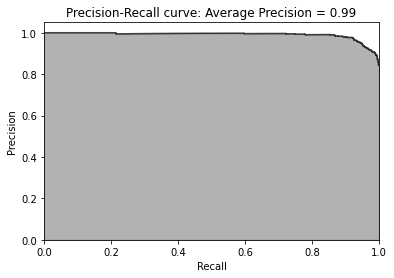

In [47]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticBoosting = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

### ROC Curve

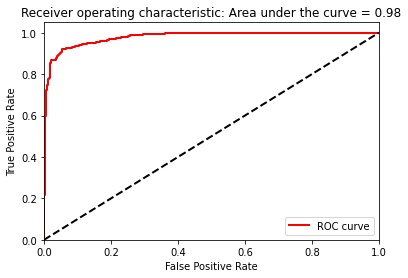

In [48]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Overall Comparison

So far we have tested 3 models for a classification problem and test them on the training set. Lets see how good they are with the test data (spared at the very begining).

We will call our models one by one:

In [49]:
#Logistic Regression:
predictionsTestSetLogisticRegression = pd.DataFrame(data=[],index=y_test.index,columns=[0,1])

predictionsTestSetLogisticRegression.loc[X_test.index,:] = logReg.predict_proba(X_test)
logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression.loc[X_test.index,1])

print('Log loss of LogReg model: ', logLossTestSetLogisticRegression)

Log loss of LogReg model:  0.3795870799441478


For the training data, it was  0.3697705832835482.

In [50]:
#SGD:
predictionsTestSetSGD = pd.DataFrame(data=[],index=y_test.index,columns=[0,1])

predictionsTestSetSGD.loc[X_test.index,:] = SGD.predict_proba(X_test)
logLossTestSetSGD = log_loss(y_test, predictionsTestSetSGD.loc[X_test.index,1])

print('Log loss of SGD model: ', logLossTestSetSGD)

Log loss of SGD model:  0.48679105799535266


For the training data, it was 0.4800090752763569.

In [51]:
#RFC:
predictionsTestSetRFC = pd.DataFrame(data=[],index=y_test.index,columns=[0,1])

predictionsTestSetRFC.loc[X_test.index,:] = RFC.predict_proba(X_test)
logLossTestSetRFC = log_loss(y_test, predictionsTestSetRFC.loc[X_test.index,1])

print('Log loss of RFC model: ', logLossTestSetRFC)

Log loss of RFC model:  0.4903599782040405


For the training data, it was 4800090752763569.

In [52]:
#Boosting with LightGBM:
predictionsTestSetGBM = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])

predictionsTestSetGBM.loc[X_test.index,'prediction'] =GBM.predict(X_test, num_iteration=GBM.best_iteration)
logLossTestSetGBM = log_loss(y_test,predictionsTestSetGBM.loc[X_test.index,'prediction'])

print('Log loss of SGD model: ', logLossTestSetGBM)

Log loss of SGD model:  0.18323968508249483


For the training data, it was 0.16512667434235095.

## Log Loss Analysis

The next question is whether the obtained log loss is reasonable or not. In binary classification (N=2), as in here, worst performance can be estimated from the limiting solution (random guess):

`Logloss = -log(1 / N) = 0.693`

But here we assume that the data is homogeneous. If we look at how the data is distributed, we see that it is as follows:

`
1    1073
`

`
0     430
`

Then the probability would be equal to prevalence:

`
p(i) = prevalence(i)
`

So you need to calculate the log loss according to the dataset:

`
p(i) = 0.7139055222887558
`

`
Log loss ~ 0.6
`

So, it may be a good practice to check first what would be the log loss for your case:

$$Log Loss = -\frac{1}{N_{positive} + N_{negative}}(\sum_{n=1}^{N_{positive}} log(p(y_i)) + \sum_{n=1}^{N_{negative}} log(1-p(y_i)))$$





In [53]:
#Calculation example
import math
p = 0.8 #= prevalence(i)
N_case = 100 #example case number
N_pos = 100*p
N_neg = 100*(1-p)
log_loss_prevalence = -1/N_case*(math.log(p)*N_pos + math.log(1-p)*N_neg)
log_loss_prevalence

0.5004024235381879

Text(0.5, 1.0, 'Variation of the Random Log Loss with Prevalence')

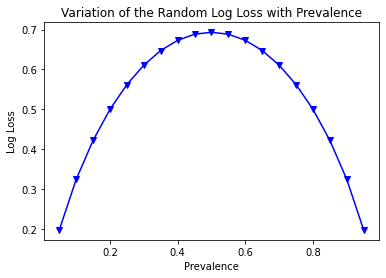

In [54]:
#Lets use the function to generate a graph:
import math
def log_loss_cal(p):
  "Return the log loss of the given prevalence"
  N_case = 100 #example case number
  N_pos = 100*p
  N_neg = 100*(1-p)
  log_loss_prevalence = -1/N_case*(math.log(p)*N_pos + math.log(1-p)*N_neg)
  return log_loss_prevalence


losses_example = []
prevalence = []
for i in range(1,20):
    prevalence.append(i*0.05)
    losses_example.append(log_loss_cal(i*0.05))
#............................
#Plotting the results:
# importing the matplotlib
# see https://matplotlib.org/
#............................
import matplotlib.pyplot as plt
plt.plot(prevalence, losses_example,'-',marker='v', color='b',label="Log Loss")
plt.xlabel("Prevalence")
plt.ylabel("Log Loss")
plt.title("Variation of the Random Log Loss with Prevalence")

### Graphical Results

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.93')

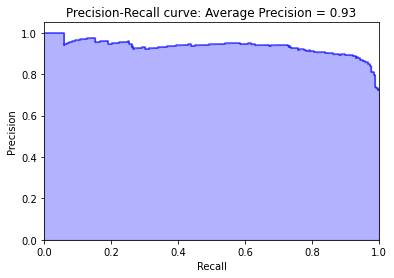

In [55]:
#Logistic Regression:
preds = pd.concat([y_test,predictionsTestSetLogisticRegression.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

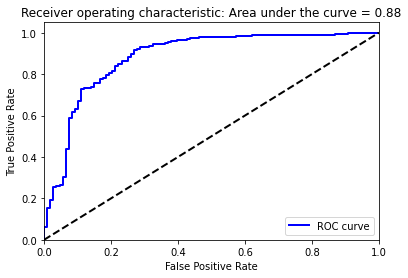

In [56]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.93')

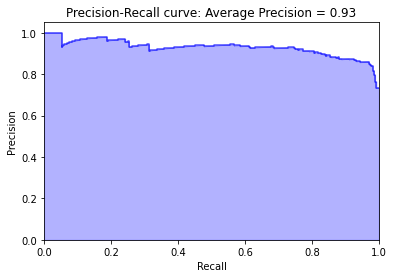

In [57]:
#SGD 
preds = pd.concat([y_test,predictionsTestSetSGD.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

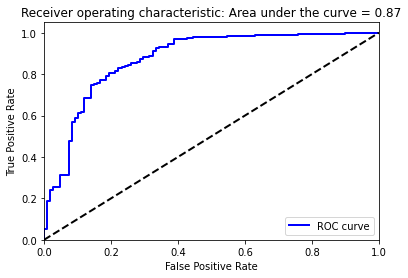

In [58]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.98')

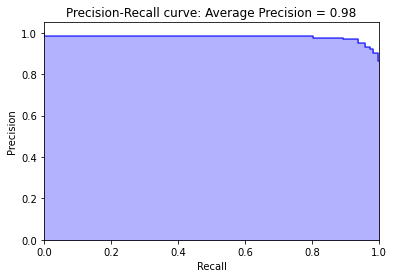

In [59]:
#RFC
preds = pd.concat([y_test,predictionsTestSetRFC.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

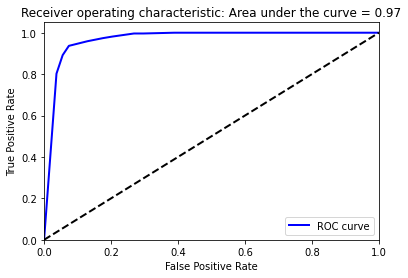

In [60]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.99')

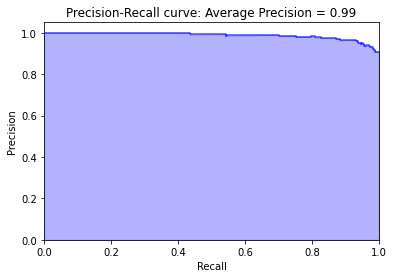

In [61]:
#Boosting
preds = pd.concat([y_test,predictionsTestSetGBM.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

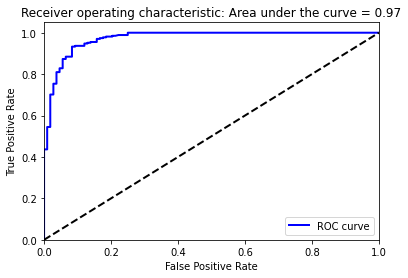

In [62]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# How can I use the models then?
Lets call some variables and try to see the model predictions. Lets remember the data strcture and create a new instance:

In [63]:
data.sample(5)

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
238,2500,0.0,0.2286,31.7,0.002724,123.445
378,500,5.3,0.2286,39.6,0.006143,132.251
1128,8000,12.7,0.0254,71.3,0.012181,120.538
1096,6300,9.5,0.0254,39.6,0.004498,120.324
968,10000,0.0,0.0254,71.3,0.000401,130.787


In [64]:
# Test Problem:
test_data = [[3600, 12, 0.11, 43, 0.0041]]

#Model Tests
logReg.predict(test_data), SGD.predict(test_data), RFC.predict(test_data), GBM.predict(test_data).round(0).astype(int)

(array([0]), array([0]), array([0]), array([0]))

## Saving / Loading Models

We have successfully finished our first ML exercise. If you want to save your models for later usage so as not to train again and again, you can do as follows:

In [65]:
#Saved model name:
import joblib
joblib_file = "LR_pickled.pkl"
joblib.dump(RFC, joblib_file)

['LR_pickled.pkl']

But this is not stored on your local machine. To download it locally:

In [66]:
from google.colab import files
files.download('LR_pickled.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
#Reloading
RFC_new = joblib.load(joblib_file)
RFC_new

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)

You can see the current CM directory as follows:

In [68]:
os.listdir('.')

['.config', 'LR_pickled.pkl', 'sample_data']

It is also possible to use your google drive for data storage via PyDrive

In [69]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Upload a file
uploaded = drive.CreateFile({'title': 'LR_pickled.pkl'})
uploaded.SetContentString('Pickled model')
uploaded.Upload()

#The file is uploaded to your google drive!


In [70]:
#Downloading a file from Google Drive:
downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Downloaded content "Pickled model"


In [71]:
os.listdir('.')

['.config', 'adc.json', 'LR_pickled.pkl', 'sample_data']

# Self exercises



1.   Change the criteria for the noise level and see the outcomes.
2.   Play with k-fold parameters. Experience the role of CV approach.
3.   Check the scikit-learn library and experiment with another method. Implement it as the 4th alternative approach.

